# Oscillating Circuit Analysis

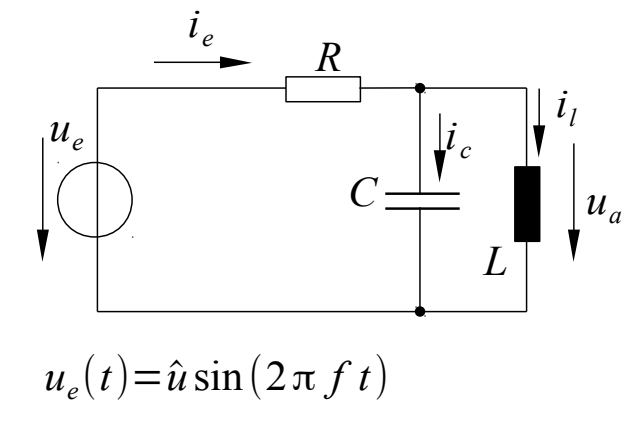

Passwort Lösungenordner: rooyen

In [56]:
from math import pi
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy import integrate as sci
from OMPython import ModelicaSystem
import pandas as pd

In [23]:
VOLTAGE_MAX =   2       # V
FREQUENCY   =   1       # Hz
RESISTOR    =   20      # Ohm
COIL        =   9e-3    # H
CAPACITOR   =   1000e-6 # F

TOTALTIME   =   2       # s
TIMESTEP    =   1e-3    # s

In [54]:
def create_plot(x, x_label, y1, y1_label, y1_unit, y12, y12_label, y12_unit, y2, y2_label, y2_unit, y22, y22_label, y22_unit, title):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle(f"{title}")

    ax1.plot(x, y1, label=f"{y1_label}", color="b")
    ax1.set_ylabel(f"{y1_unit}")

    ax12 = ax1.twinx() if y12 is not None else None
    ax12.plot(x, y12, label=f"{y12_label}", color="m") if y12 is not None else None
    # ax12.set_ylim(top=0.003)
    ax12.set_ylabel(f"{y12_unit}") if y12 is not None else None


    ax2.plot(x, y2, label=f"{y2_label}", color="g")
    ax2.set_ylabel(f"{y2_unit}")

    ax22 = ax2.twinx() if y22 is not None else None
    ax22.plot(x, y22, label=f"{y22_label}", color="r")  if y22 is not None else None
    # ax22.set_ylim(top=0.15)
    ax22.set_ylabel(f"{y22_unit}") if y22 is not None else None

    ax2.set_xlabel(f"{x_label}")
    fig.legend()
    plt.show()

## Solving ODE with SCIPY-Function

In [50]:
time=np.linspace(0, TOTALTIME, int(TOTALTIME/TIMESTEP)+1)

SYSTEM_ARRAY=np.array([[-1/(RESISTOR*CAPACITOR),    -1/CAPACITOR], 
                       [1/COIL,                    0]])
INPUT_ARRAY=np.array([[1/(RESISTOR*CAPACITOR)],
                      [0]])
OUTPUT_ARRAY=np.array([[1,              0],
                        [0,             1],
                        [-1/RESISTOR,    0]])
TRANSIT_ARRAY=np.array([[0],
                        [0],
                        [1/RESISTOR]]) # type: ignore

INITIAL_STATE = np.array([0,0])     # = [outputvoltage, outputcurrent]

def input_voltage(time):
    return VOLTAGE_MAX * np.sin(2 * pi * FREQUENCY * time)

def state_derivative(time, state):
    state=np.reshape(state, (2,1))
    state_derivative = SYSTEM_ARRAY.dot(state) + INPUT_ARRAY * input_voltage(time)
    return np.reshape(state_derivative, (1,2)) 

def output_array(state, time):
    return OUTPUT_ARRAY.dot(state) + TRANSIT_ARRAY * input_voltage(time)

ode_solution = sci.solve_ivp(state_derivative, [0, TOTALTIME], INITIAL_STATE, t_eval=time).y

output_array = output_array(ode_solution, time)

array([<Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>,
       <Axes: xlabel='time in s'>, <Axes: xlabel='time in s'>],
      dtype=object)

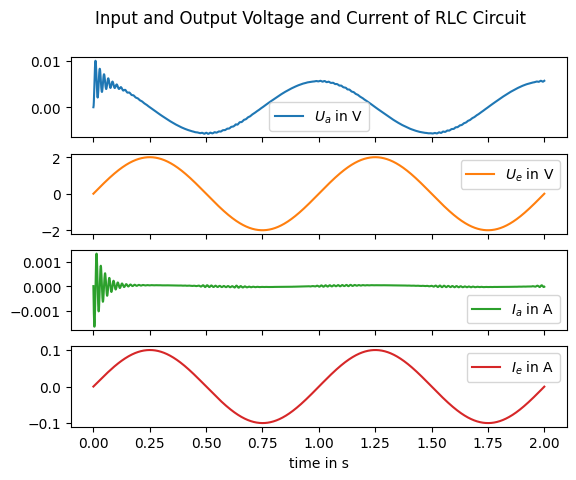

In [70]:
dataframe = pd.DataFrame({
    "time in s": time,
    "$U_a$ in V": output_array[0], 
    "$U_e$ in V": input_voltage(time), 
    "$I_a$ in A": output_array[1] - output_array[2],
    "$I_e$ in A": output_array[2]})

dataframe = dataframe.set_index("time in s")

dataframe.plot(subplots=True, title="Input and Output Voltage and Current of RLC Circuit")

### Explanation
Das Entfernen von `method='LSODA'` hat keinen Effekt. Die Scipy-Funktion wählt eigenständig eine geeignete Methode aus.

Die Energie wird zwischen Kondensator und Spule periodisch ausgetauscht. Ihr komplexer Widerstand kompensiert sich. Bei ausreichender Kompensation dominiert der ohmsche Verbraucher.

## Solving ODE with Open-Modelica and constant parameters

In [27]:
modelname = "resonant_circuit"
model = ModelicaSystem(modelname+".mo", modelname)
model.setSimulationOptions('stopTime=5.0')

model.simulate()

Exception ignored in: <function ModelicaSystem.__del__ at 0x000001F320029080>
Traceback (most recent call last):
  File "c:\Users\janho\scoop\apps\python\current\Lib\site-packages\OMPython\__init__.py", line 862, in __del__
    OMCSessionBase.__del__(self)
  File "c:\Users\janho\scoop\apps\python\current\Lib\site-packages\OMPython\__init__.py", line 172, in __del__
    self._omc_log_file.close()
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'ModelicaSystem' object has no attribute '_omc_log_file'


Notification: Automatically loaded package Complex 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package ModelicaServices 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package Modelica 4.0.0 due to usage.



In [28]:
output_voltage = model.getSolutions("u_a")
input_voltage = model.getSolutions("u_e")
time = model.getSolutions('time')

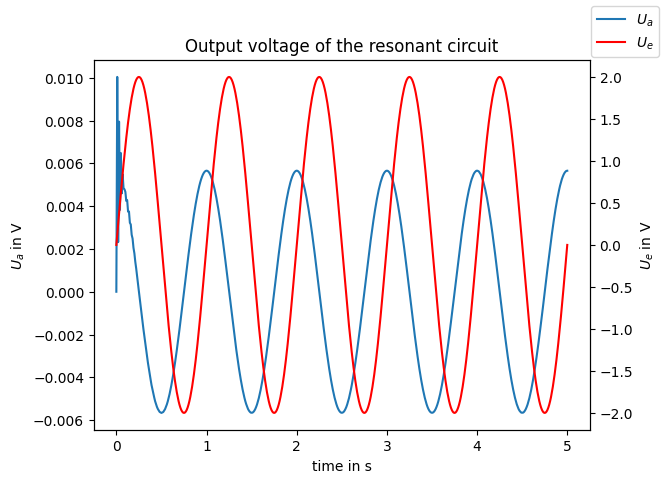

In [29]:
fig, ax1 = plt.subplots()
ax1.plot(time[0], output_voltage[0], label="$U_a$")
ax1.set_xlabel("time in s")
ax1.set_ylabel("$U_a$ in V")

ax2 = ax1.twinx()
ax2.plot(time[0], input_voltage[0], label="$U_e$", color ="red")
ax2.set_ylabel("$U_e$ in V")

plt.title("Output voltage of the resonant circuit")
fig.legend()
plt.show()

## Solving ODE with Open-Modelica and variable parameters

In [30]:
modelname = "blockdiagram"
model = ModelicaSystem(modelname+".mo", modelname)

model.setSimulationOptions('stopTime=2.0')
model.setParameters('resistor1.R='+str(RESISTOR))
model.setParameters('inductor1.L='+str(COIL))
model.setParameters('capacitor1.C='+str(CAPACITOR))

model.simulate()

Notification: Automatically loaded package Complex 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package ModelicaServices 4.0.0 due to uses annotation from Modelica.
Notification: Automatically loaded package Modelica 4.0.0 due to usage.
[C:/Users/janho/AppData/Roaming/.openmodelica/libraries/Modelica 4.0.0+maint.om/Electrical/Analog/Sources/SineVoltage.mo:5:3-5:61:writable] Warning: Parameter sineVoltage1.f has no value, and is fixed during initialization (fixed=true), using available start value (start=1.0) as default value.



In [31]:
[output_voltage] = model.getSolutions("inductor1.v")
[output_current] = model.getSolutions("capacitor1.i")
[input_voltage] = model.getSolutions("sineVoltage1.v")
[input_current] = model.getSolutions("sineVoltage1.i")
[time] = model.getSolutions('time')

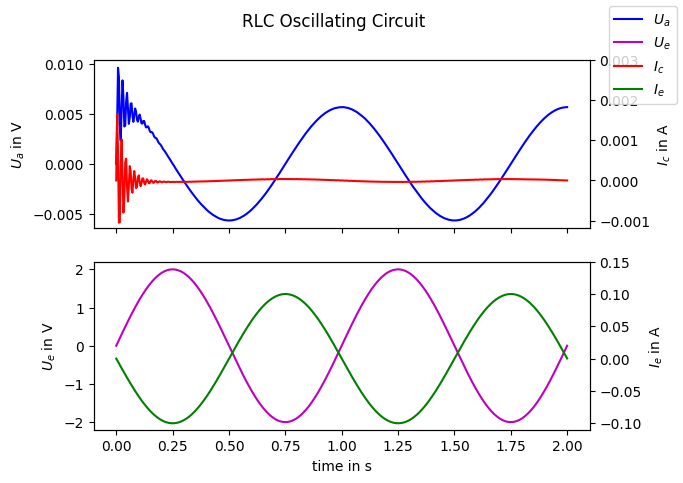

In [32]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle("RLC Oscillating Circuit")


ax1.plot(time, output_voltage, label="$U_a$", color="b")
ax1.set_ylabel("$U_a$ in V")
ax12 = ax1.twinx()
ax12.plot(time, output_current, label="$I_c$", color="r")
ax12.set_ylim(top=0.003)
ax12.set_ylabel("$I_c$ in A")


ax2.plot(time, input_voltage, label="$U_e$", color ="m")
ax2.set_ylabel("$U_e$ in V")
ax22 = ax2.twinx()
ax22.plot(time, input_current, label="$I_e$", color="g")
ax22.set_ylim(top=0.15)
ax22.set_ylabel("$I_e$ in A")

ax2.set_xlabel("time in s")
fig.legend()
plt.show()

## Frequencies of the Circuit

In [33]:
model.setSimulationOptions('stopTime=0.1')
model.simulate()

In [34]:
[output_voltage] = model.getSolutions("inductor1.v")
[output_current] = model.getSolutions("capacitor1.i")
[input_voltage] = model.getSolutions("sineVoltage1.v")
[input_current] = model.getSolutions("sineVoltage1.i")
[time] = model.getSolutions('time')

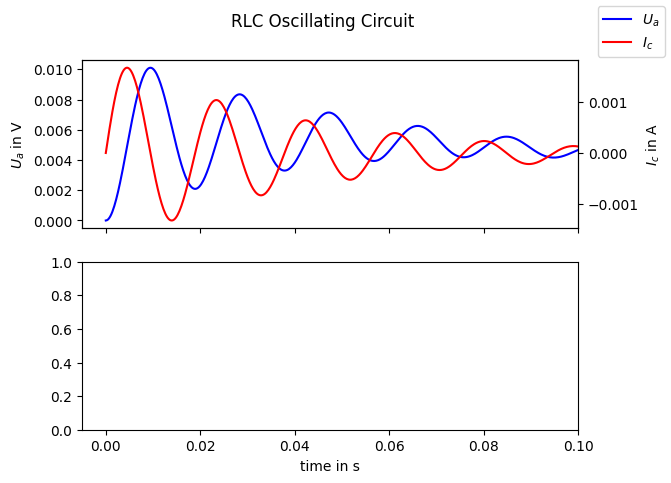

In [35]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle("RLC Oscillating Circuit")


ax1.plot(time, output_voltage, label="$U_a$", color="b")
ax1.set_ylabel("$U_a$ in V")
ax1.set_xlim(right=0.1)
ax12 = ax1.twinx()
ax12.plot(time, output_current, label="$I_c$", color="r")
# ax12.set_ylim(top=0.003)
ax12.set_ylabel("$I_c$ in A")


# ax2.plot(time, input_voltage, label="$U_e$", color ="m")
# ax2.set_ylabel("$U_e$ in V")
# ax1.set_xlim(right=0.1)
# ax22 = ax2.twinx()
# ax22.plot(time, input_current, label="$I_e$", color="g")
# # ax22.set_ylim(top=0.15)
# ax22.set_ylabel("$I_e$ in A")

ax2.set_xlabel("time in s")
fig.legend()
plt.show()

### Explanation
Resonanzfrequenz von ...

## Bode Diagram

In [36]:
numerator = [COIL, 0]
denominator = [COIL * CAPACITOR * RESISTOR, COIL, RESISTOR]

system = sig.TransferFunction(numerator, denominator)
omega, magnitude, phase = sig.bode(system)
zeros = system.zeros
poles = system.poles

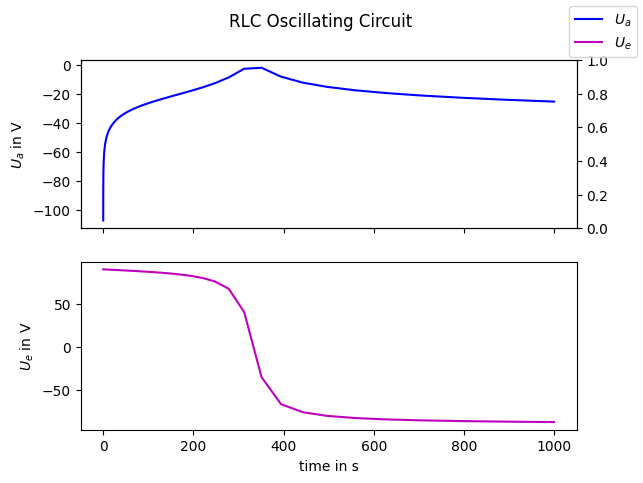

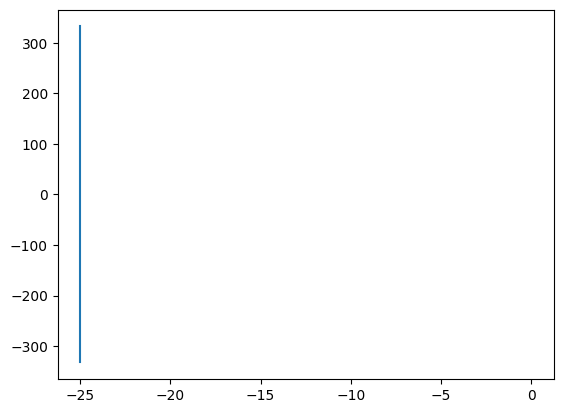

In [37]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle("RLC Oscillating Circuit")


ax1.plot(omega, magnitude, label="$U_a$", color="b")
ax1.set_ylabel("$U_a$ in V")
# ax1.set_xlim(right=0.1)
ax12 = ax1.twinx()
# ax12.plot(time, output_current, label="$I_c$", color="r")
# ax12.set_ylim(top=0.003)
# ax12.set_ylabel("$I_c$ in A")


ax2.plot(omega, phase, label="$U_e$", color ="m")
ax2.set_ylabel("$U_e$ in V")
# ax1.set_xlim(right=0.1)
# ax22 = ax2.twinx()
# ax22.plot(time, input_current, label="$I_e$", color="g")
# # ax22.set_ylim(top=0.15)
# ax22.set_ylabel("$I_e$ in A")

ax2.set_xlabel("time in s")
fig.legend()
plt.show()

plt.plot(poles.real, poles.imag)
plt.plot(zeros.real, zeros.imag)